In [13]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [14]:
import os
from langsmith_tracker import set_tracking
from langchain_print import stream_response
from multimodal import MultiModal
from tools_news import GoogleNews

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### LangGraph 챗봇 구축

챗복 구축을 위한 LangGraph 코드 예시입니다.

#### Step by Step 이해하기

##### STEP 1. 상태(State) 정의


In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    # 메시지 리스트를 저장하는 상태 키
    messages: Annotated[list, add_messages]

##### STEP 2. 노드(Node) 정의

`chatbot` 노드를 추가합니다.  
  
노드는 작업 단위를 말하는 것이며, 일반적으로 사용자가 작성한 정규 Python 함수를 입니다.

In [5]:
from langchain_openai import ChatOpenAI

# llm 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 노드 정의, 함수 정의
def chatbot(state: GraphState):
    # 메시지 리스트 반환
    return {"messages": [llm.invoke(state["messages"])]}
    # return State(messages=llm.invoke(state["messages"])) # 문법 가능

##### STEP 3. 그래프(Graph) 정의, 노드 추가

`chatbot` 노드 함수는 

In [9]:
# 그래프 생성
graph_builder = StateGraph(GraphState)

# 노드 이름, 합수 혹인 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

##### STEP 4. 그래프 엣지(Edge) 정의

<span style="color:#1e73be; background-color:#363a43">START</span> 지점을 추가합니다. <span style="color:#1e73be; background-color:#363a43">START</span> 는 그래프가 시작될 때마다 **작업을 시작할 위치** 입니다.



In [10]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

<span style="color:#1e73be; background-color:#363a43">END</span> 지점을 추가합니다. <span style="color:#1e73be; background-color:#363a43">END</span> 는 그래프 흐름을 종료(끝지점)를 나타냅니다.

In [11]:
# 종료 엣지 추가
graph_builder.add_edge("chatbot", END)

##### STEP 5. 그래프 컴파일(Compile)

그래프를 실행할 수 있도록 컴파일합니다. 이를 위해 그래프 빌더에서 `compile()` 메서드를 호출합니다. `compile()`은 `CompiledGraph` 객체를 반환합니다.

In [12]:
# 그래프 컴파일
graph = graph_builder.compile()

##### STEP 6. 그래프 시각화

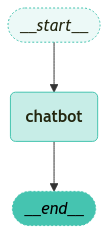

In [15]:
from graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

##### STEP 7. 그래프 실행

In [16]:
question = "밈코인 TOP10 추천해줘"

# 그래프 이벤트 스트리밍, 토큰 스트림과 다릅니다. langgraph의 stream() 메서드는 중간에 노드단위의 출력물을 출력할때 사용하는 것입니다.
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 2023년 기준으로 인기 있는 밈코인 TOP 10을 추천해드리겠습니다. 다만, 암호화폐 시장은 변동성이 크기 때문에 투자 결정을 내리기 전에 충분한 조사와 분석이 필요합니다.

1. **도지코인 (Dogecoin, DOGE)** - 가장 유명한 밈코인으로, 커뮤니티와 유명 인사들의 지지로 큰 인기를 끌고 있습니다.
2. **시바이누 (Shiba Inu, SHIB)** - 도지코인의 대안으로 떠오른 밈코인으로, 강력한 커뮤니티와 다양한 프로젝트를 가지고 있습니다.
3. **호가치코인 (Hoge Finance, HOGE)** - 디플레이션 모델을 채택한 밈코인으로, 커뮤니티 중심의 프로젝트입니다.
4. **사토시 나카모토 (Satoshi Nakamoto, SATS)** - 비트코인의 창시자를 기리기 위해 만들어진 밈코인입니다.
5. **킵코인 (Kishu Inu, KISHU)** - 또 다른 도지코인 대안으로, 커뮤니티와 생태계 구축에 중점을 두고 있습니다.
6. **파피코인 (Poodle, POODLE)** - 유머와 재미를 강조하는 밈코인으로, 다양한 커뮤니티 활동을 통해 인기를 얻고 있습니다.
7. **엘론 머스크 도그 (Elon Musk Doge, ELON)** - 유명 인사인 엘론 머스크와 관련된 밈코인입니다.
8. **아프리카 도지 (Doge Africa, AFD)** - 아프리카 시장을 겨냥한 밈코인으로, 지역 사회와의 연계를 강조합니다.
9. **스페이스 도지 (SpaceDoge, SDOGE)** - 우주와 관련된 테마를 가진 밈코인으로, 독특한 컨셉을 가지고 있습니다.
10. **도지캐시 (DogeCash, DOGEC)** - 도지코인의 파생형으로, 다양한 기능과 사용 사례를 제공합니다.

이 리스트는 시장 상황에 따라 변동될 수 있으며, 각 코인의 기술적 기반이나 커뮤니티 활동 등을 고려하여 신중하게 투자 결정을 하시기 바랍니다.


### 전체 코드

아래 코드 순서에 익숙해지는 것이 중요합니다.

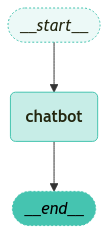

Assistant: 2023년 기준으로 인기 있는 밈코인 TOP 10을 추천해드리겠습니다. 다만, 암호화폐 시장은 변동성이 크기 때문에 투자 결정을 내리기 전에 충분한 조사와 분석이 필요합니다.

1. **도지코인 (Dogecoin, DOGE)** - 원래 농담으로 시작된 코인이지만, 큰 커뮤니티와 유명 인사들의 지지로 인기를 끌고 있습니다.

2. **시바이누 (Shiba Inu, SHIB)** - 도지코인의 대안으로 등장한 밈코인으로, 강력한 커뮤니티와 다양한 프로젝트를 가지고 있습니다.

3. **호가치코인 (Hoge Finance, HOGE)** - 반감기 메커니즘을 가진 밈코인으로, 커뮤니티 중심의 프로젝트입니다.

4. **사토시코인 (Satoshi Coin, SATS)** - 비트코인의 창시자 사토시 나카모토를 기리기 위해 만들어진 코인입니다.

5. **킵코인 (Kishu Inu, KISHU)** - 또 다른 도지코인 대안으로, 커뮤니티와 생태계 구축에 중점을 두고 있습니다.

6. **파피코인 (Poodle Coin, POODLE)** - 유머와 재미를 중심으로 한 프로젝트로, 다양한 커뮤니티 활동을 진행하고 있습니다.

7. **엘론 머스크 도그 (Elon Musk Doge, ELON)** - 유명 인사 엘론 머스크와 관련된 테마의 밈코인입니다.

8. **아카시코인 (Akita Inu, AKITA)** - 시바이누와 유사한 컨셉의 밈코인으로, 커뮤니티의 지지를 받고 있습니다.

9. **스페이스 도지 (SpaceDoge, SDOGE)** - 우주 테마의 밈코인으로, 다양한 NFT 프로젝트와 연계되어 있습니다.

10. **코인마켓도그 (CoinMarketDoge, CMD)** - 도지코인을 기반으로 한 다양한 프로젝트와 연계된 코인입니다.

이 리스트는 시장 상황에 따라 변동될 수 있으며, 각 코인의 특성과 리스크를 충분히 이해한 후 투자 결정을 하시기 바랍니다.


In [18]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from graphs import visualize_graph


##### STEP 1. 상태(State) 정의
class GraphState(TypedDict):
    # 메시지 리스트를 저장하는 상태 키
    messages: Annotated[list, add_messages]


##### STEP 2. 노드(Node) 정의
# llm 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 노드 정의, 함수 정의
def chatbot(state: GraphState):
    # 메시지 리스트 반환
    return {"messages": [llm.invoke(state["messages"])]}
    # return State(messages=llm.invoke(state["messages"])) # 문법 가능


##### STEP 3. 그래프(Graph) 정의, 노드 추가
# 그래프 생성
graph_builder = StateGraph(GraphState)

# 노드 이름, 합수 혹인 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)


##### STEP 4. 그래프 엣지(Edge) 정의
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

# 종료 엣지 추가
graph_builder.add_edge("chatbot", END)


##### STEP 5. 그래프 컴파일
# 그래프 컴파일
graph = graph_builder.compile()


##### STEP 6. 그래프 시각화
# 그래프 시각화
visualize_graph(graph)


##### STEP 7. 그래프 실행
question = "밈코인 TOP10 추천해줘"

# 그래프 이벤트 스트리밍, 토큰 스트림과 다릅니다. langgraph의 stream() 메서드는 중간에 노드단위의 출력물을 출력할때 사용하는 것입니다.
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)